## LSTM Autoencoders for Unsupervised Clustering


</br></br>

### Import Data and Libraries
---

In [ ]:
!pip install aeon

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from aeon.datasets import load_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

</br></br>

### EDA
---
- Plot class distribution
- Plot samples of data

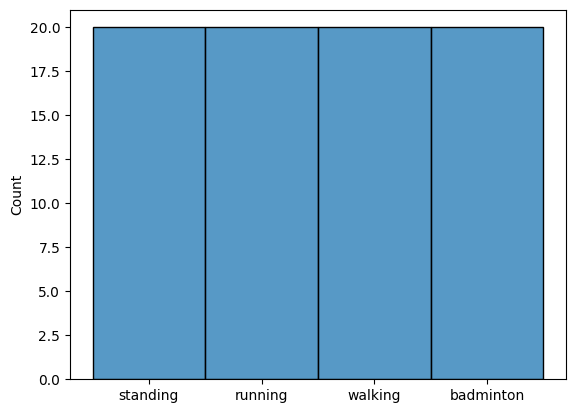

In [ ]:
X, y = load_classification("BasicMotions")
sns.histplot(y);

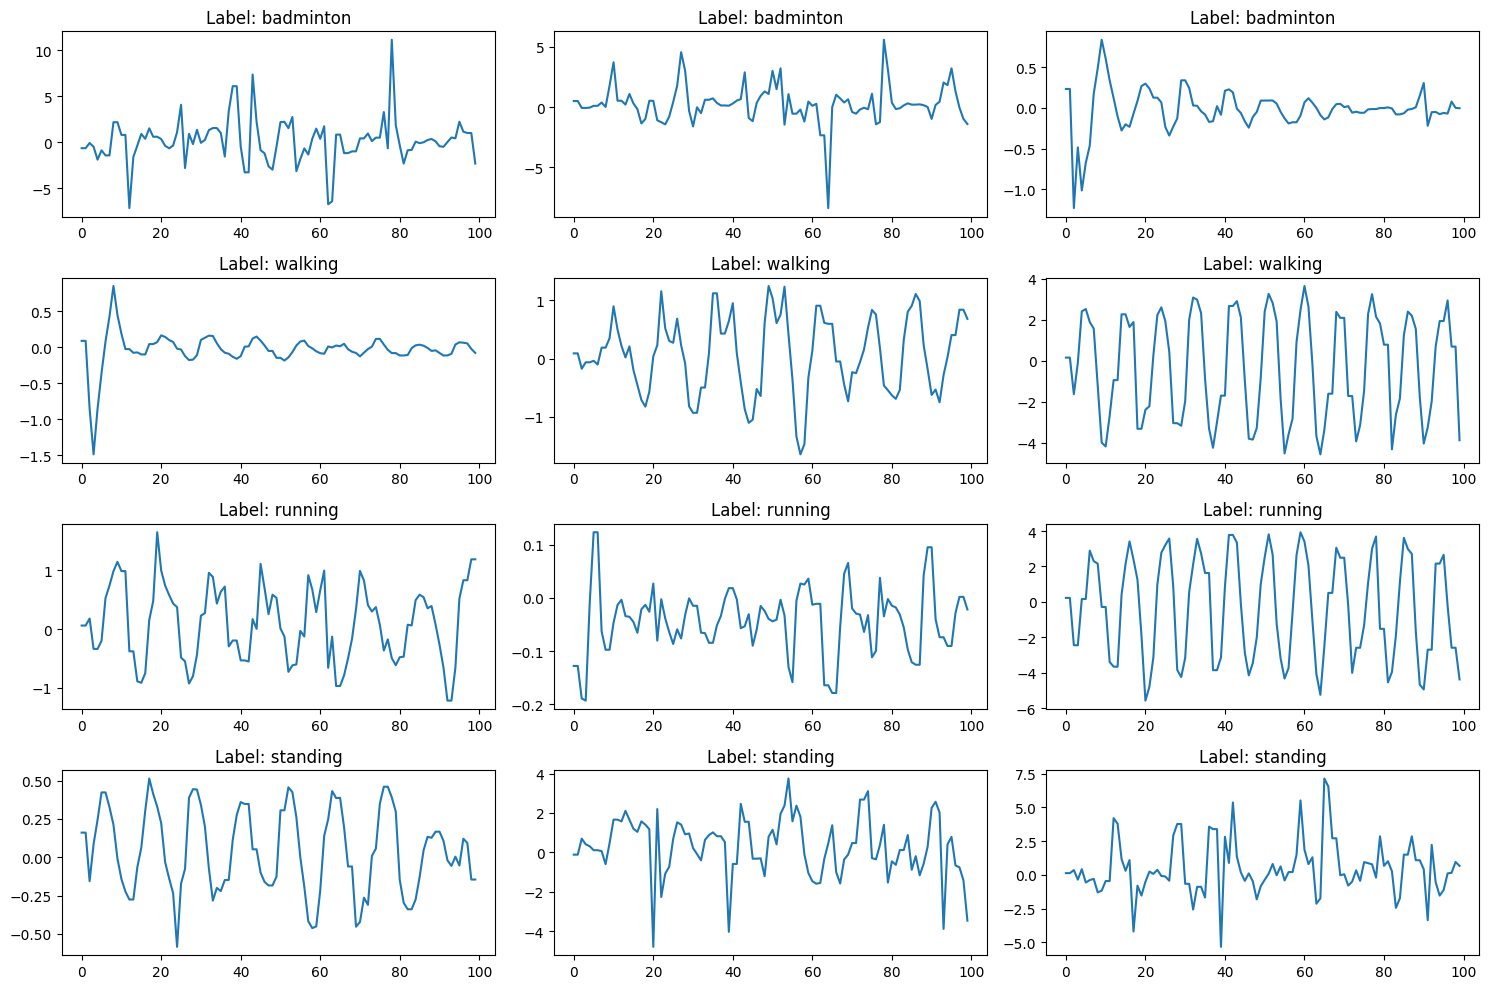

In [ ]:
X, y = load_classification("BasicMotions")
X = torch.tensor(X).mean(dim=1)
X = X[torch.randperm(X.shape[0])]

plt.figure(figsize=(15, 10))
unique_labels = list(set(y))
samples_per_label = 3
total_classes = len(unique_labels)

for idx, label in enumerate(unique_labels):
    count = 0
    for i in range(len(y)):
        if y[i] == label and count < samples_per_label:
            plt.subplot(total_classes, samples_per_label,
                        idx * samples_per_label + count + 1)
            plt.title(f"Label: {y[i]}")
            plt.plot(X[i])
            count += 1

plt.tight_layout()
plt.show()

</br></br>

### Preprocess Data
---
- Encode labels
- Train/Test split
- Transform data into batches
- Shuffle and Randomize

In [ ]:
X, y = load_classification("BasicMotions")
X.shape, y.shape

((80, 6, 100), (80,))

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.random.seed(500)
seed = 1200
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
train_len = int(len(y) * 0.6)

train_indices = torch.tensor(np.random.choice(range(80), size=(train_len,), replace=False))
test_indices  = torch.tensor([i for i in range(80) if i not in train_indices])

B, T, C = X.shape
NUM_CLASSES = len(set(y))

X_train = torch.tensor(X[train_indices]).float().reshape((-1, C, T)).to(DEVICE)
y_train = torch.tensor(y[train_indices]).float().to(DEVICE)
X_test  = torch.tensor(X[test_indices]).float().reshape((-1, C, T)).to(DEVICE)
y_test  = torch.tensor(y[test_indices]).float().to(DEVICE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([48, 100, 6]),
 torch.Size([48]),
 torch.Size([32, 100, 6]),
 torch.Size([32]))

In [ ]:
class BasicMotions(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return (self.X[idx], self.y[idx])

In [ ]:
train_data = DataLoader(BasicMotions(X_train, y_train), batch_size=8, shuffle=True)
test_data  = DataLoader(BasicMotions(X_test,  y_test),  batch_size=8, shuffle=True)

</br></br>

### Create Autoencoder Architecture
---

`Encoder`:
- Transforms the input (B x L x N) --> (B x L x 1) by projecting to a higher dimension first and then learning a more compact latent representation afterwards. 'N' dimension transformations: [6 -> 100 -> 50 -> 40 -> 8 -> 1]
- Leaky relu is used rather than relu to prevent dead neurons due to negative preactivations, which cause gradients to be 0 leading to no optimization, led to better results.
- Bidirectional layers process the input forwards and backwards, led to better results.

</br>

`Decoder`:
- Reconstructs the original input by reversing the transformations taken place in the encoder. 'N' dimension transformations: [1 -> 8 -> 40 -> 50 -> 100 -> 6]
- Leaky relu and bidirectional here too.

</br>

`LSTMAutoencoder`
- Training: encoder encoders input and decoder decodes the output of the encoder
- Testing: encoder encodes input and then untrained lstm transforms (B x L x 1) encoder output into (B x NUM_CLASSES) final output, which gets softmaxed

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_features, hidden_size, latent_dim):
        super().__init__()
        self.e1  = nn.LSTM(6, 50,   bidirectional=True, batch_first=True)
        self.e2  = nn.LSTM(100, 25, bidirectional=True, batch_first=True)
        self.e3  = nn.LSTM(50, 10,  bidirectional=True, batch_first=True)
        self.e4  = nn.LSTM(20, 2,   bidirectional=True, batch_first=True)
        self.e5  = nn.LSTM(4, 1,    batch_first=True)

    def forward(self, x):
      x = F.leaky_relu((self.e1(x)[0]), 0.2)
      x = F.leaky_relu((self.e2(x)[0]), 0.2)
      x = F.leaky_relu((self.e3(x)[0]), 0.2)
      x = F.leaky_relu((self.e4(x)[0]), 0.2)
      x = self.e5(x)[0]

      return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_features, hidden_size, latent_dim):
      super().__init__()
      self.d1 = nn.LSTM(1, 2,   bidirectional=True, batch_first=True)
      self.d2 = nn.LSTM(4, 10,  bidirectional=True, batch_first=True)
      self.d3 = nn.LSTM(20, 25, bidirectional=True, batch_first=True)
      self.d4 = nn.LSTM(50, 50, bidirectional=True, batch_first=True)
      self.d5 = nn.LSTM(100, 6, batch_first=True)

    def forward(self, x):
      x = F.leaky_relu((self.d1(x)[0]), 0.2)
      x = F.leaky_relu((self.d2(x)[0]), 0.2)
      x = F.leaky_relu((self.d3(x)[0]), 0.2)
      x = F.leaky_relu((self.d4(x)[0]), 0.2)
      x = self.d5(x)[0]
      return x

In [ ]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, num_features, hidden_size, latent_dim, num_classes, train=True):
      super().__init__()
      self.t = train

      self.encoder = Encoder(num_features, hidden_size, latent_dim)
      self.decoder = Decoder(num_features, hidden_size, latent_dim)

      self.o1 = nn.LSTM(hidden_size, num_classes)

    def train(self):
      self.t = True

    def eval(self):
      self.t = False

    def forward(self, x):
      if self.t:
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        return x_dec
      else:
        x_enc  = self.encoder(x)
        x_enc  = x_enc.view((x_enc.shape[0], x_enc.shape[1]))
        o1, _  = self.o1(x_enc)
        output = F.softmax(o1, dim=1)
        return output

</br></br>

### Train autoencoder
---

In [ ]:
model = LSTMAutoencoder(6, 100, 2, 4).to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [ ]:
EPOCHS = 500
model.train()
train_losses = []
test_losses  = []

for epoch in range(EPOCHS):
  train_lossi = []
  test_lossi  = []
  for x,y in train_data:
    output = model(x)
    loss   = F.mse_loss(output, x)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_lossi.append(loss.item())

  with torch.no_grad():
    for x,y in test_data:
      output = model(x)
      loss = F.mse_loss(output, x)

      test_lossi.append(loss.item())


  train_losses.append(torch.tensor(train_lossi).mean().item())
  test_losses.append(torch.tensor(test_lossi).mean().item())

  print(f"EPOCH: {epoch}  |  TRAIN LOSS: {round(train_losses[-1], 3)}  | TEST LOSS: {round(test_losses[-1], 3)}")

EPOCH: 0  |  TRAIN LOSS: 19.857  | TEST LOSS: 24.687
EPOCH: 1  |  TRAIN LOSS: 19.851  | TEST LOSS: 24.682
EPOCH: 2  |  TRAIN LOSS: 19.847  | TEST LOSS: 24.677
EPOCH: 3  |  TRAIN LOSS: 19.845  | TEST LOSS: 24.673
EPOCH: 4  |  TRAIN LOSS: 19.841  | TEST LOSS: 24.669
EPOCH: 5  |  TRAIN LOSS: 19.838  | TEST LOSS: 24.665
EPOCH: 6  |  TRAIN LOSS: 19.835  | TEST LOSS: 24.66
EPOCH: 7  |  TRAIN LOSS: 19.832  | TEST LOSS: 24.655
EPOCH: 8  |  TRAIN LOSS: 19.828  | TEST LOSS: 24.647
EPOCH: 9  |  TRAIN LOSS: 19.822  | TEST LOSS: 24.637
EPOCH: 10  |  TRAIN LOSS: 19.813  | TEST LOSS: 24.619
EPOCH: 11  |  TRAIN LOSS: 19.8  | TEST LOSS: 24.596
EPOCH: 12  |  TRAIN LOSS: 19.782  | TEST LOSS: 24.562
EPOCH: 13  |  TRAIN LOSS: 19.751  | TEST LOSS: 24.516
EPOCH: 14  |  TRAIN LOSS: 19.712  | TEST LOSS: 24.461
EPOCH: 15  |  TRAIN LOSS: 19.663  | TEST LOSS: 24.397
EPOCH: 16  |  TRAIN LOSS: 19.624  | TEST LOSS: 24.334
EPOCH: 17  |  TRAIN LOSS: 19.586  | TEST LOSS: 24.261
EPOCH: 18  |  TRAIN LOSS: 19.53  | TEST L

</br></br>

### Evaluate Model
---
- Plot sample autoencoder reconstructions
- Plot loss history

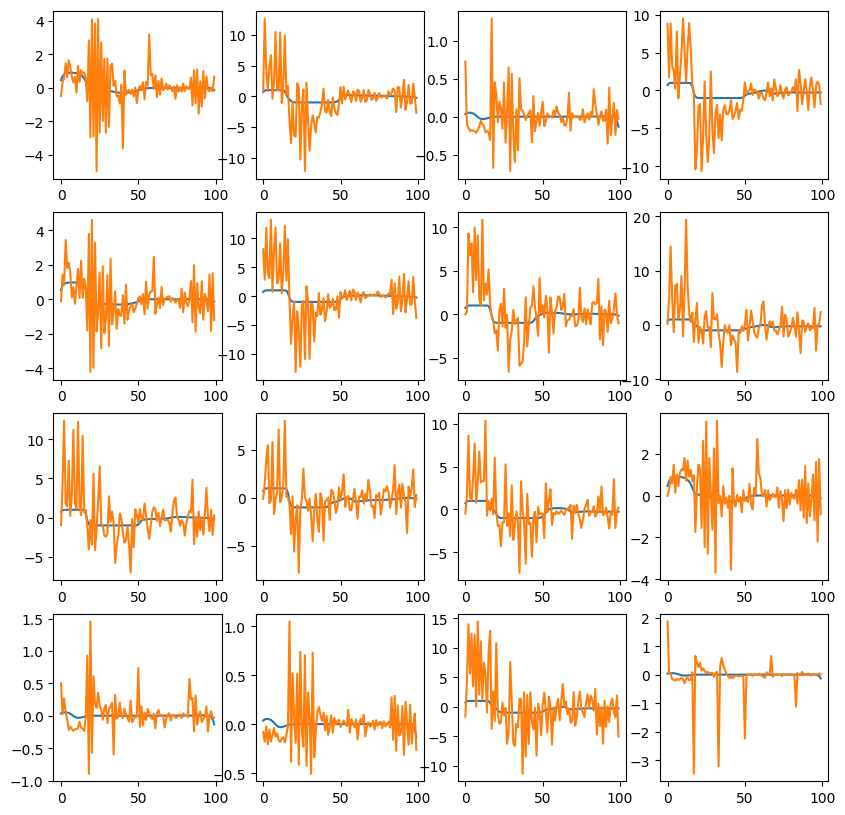

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.plot(model(X_train)[i].mean(dim=-1).detach().cpu().numpy())
  plt.plot(X_train[i].mean(dim=-1).detach().cpu().numpy())

Text(0, 0.5, 'Loss')

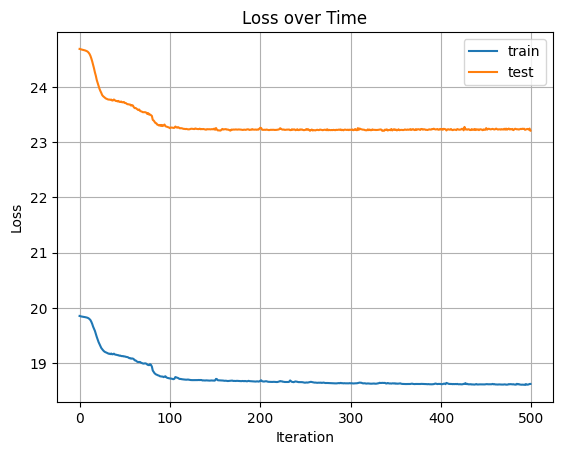

In [ ]:
sns.lineplot(train_losses, label='train')
sns.lineplot(test_losses,  label='test')
plt.grid(True)
plt.title("Loss over Time")
plt.xlabel("Iteration")
plt.ylabel("Loss")

</br></br>

### Get Output Predictions
---
- Evaluate standard softmaxed predictions
- Evaluate KMeans on latent representations

In [ ]:
def get_pred_mapper(y_pred, y_true, num_classes):
  y_pred, y_true = list(y_pred), list([int(i) for i in y_true])

  count_mat = np.zeros((num_classes, num_classes))

  for i in range(len(y_pred)):
      count_mat[y_pred[i]][y_true[i]] += 1

  mapper = {}
  for i in range(num_classes):
      mapper[i] = np.argmax(count_mat[i])

  return mapper

In [ ]:
model.eval()

output = model.encoder(X_test).mean(dim=1)
y_pred = torch.argmax(model(X_test), dim=-1).view((-1))
y_pred = y_pred.detach().cpu().numpy()

# Use the mapper to reassign the clusters
mapper = get_pred_mapper(y_pred, y_test.detach().cpu().numpy(), 4)
y_pred = [mapper[i] for i in y_pred]

Will plot 2 random dimensions from the latent space for visualization purposes.

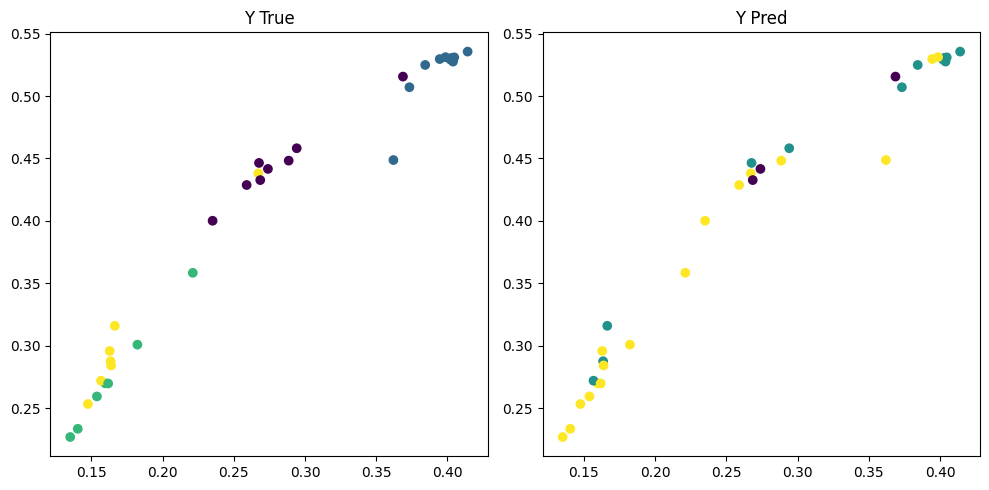

In [ ]:
plt.figure(figsize=(10, 5))

output = model.encoder(X_test).detach().cpu().numpy()

plt.subplot(1, 2, 1)
plt.title("Y True")
plt.scatter(output[:, 0], output[:, 1], c=y_test.detach().cpu().numpy(), cmap='viridis')
plt.subplot(1, 2, 2)
plt.title("Y Pred")
plt.scatter(output[:, 0], output[:, 1], c=y_pred, cmap='viridis')

plt.tight_layout();

In [ ]:
accuracy_score(y_pred, y_test.detach().cpu().numpy()) * 100

53.125

</br></br>

Now evaluate KMeans on the latent representations of the test data points from the encoder

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(4)

# output[:,:,0] since output shape is (32 x 100 x 1)
y_pred = kmeans.fit_predict(output[:,:,0])

mapper = get_pred_mapper(y_pred, y_test.detach().cpu().numpy(), 4)
y_pred = [mapper[i] for i in y_pred]

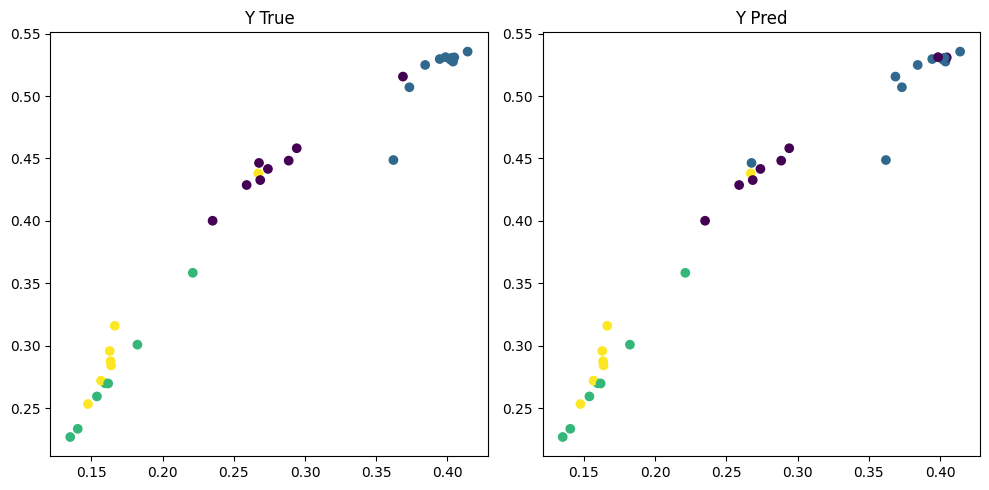

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Y True")
plt.scatter(output[:, 0], output[:, 1], c=y_test.detach().cpu().numpy(), cmap='viridis')
plt.subplot(1, 2, 2)
plt.title("Y Pred")
plt.scatter(output[:, 0], output[:, 1], c=y_pred, cmap='viridis')

plt.tight_layout();

In [ ]:
accuracy_score(y_pred, y_test.detach().cpu().numpy()) * 100

87.5